In [1]:
import pandas as pd
import numpy as np
import re
from transformers import XLNetTokenizer, XLNetForSequenceClassification, TrainingArguments, Trainer, pipeline
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import datasets
import evaluate
import random

# Loading the dataset

In [2]:
data = datasets.load_dataset("dair-ai/emotion", "split")

In [3]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

## Checking if the training dataset is balanced

We will only attempt to balance the training dataset, not the validation or test datasets.

In [4]:
pd.Series(data["train"]["label"]).value_counts()

1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64

It looks like this dataset needs to be balanced. Let's explore the data first

In [5]:
data["train"]["text"][0]

'i didnt feel humiliated'

In [6]:
data["train"]["text"]

Column(['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'])

Converting the training data into a pandas DataFrame object

In [7]:
df_train = pd.DataFrame(data["train"])

In [8]:
df_train

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


In [9]:
'''
This is required because including the grouping column in the 
resulting dataframe will soon no longer be supported.
'''
df_train["groupby_label"] = df_train["label"]

<Axes: xlabel='label'>

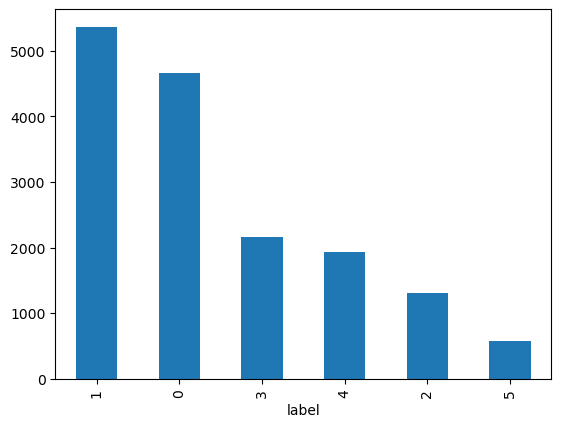

In [10]:
df_train['label'].value_counts().plot(kind="bar")

In [11]:
g = df_train.groupby("groupby_label")
df_train = pd.DataFrame(g.apply(lambda x: x.sample(int(g.size().min())).reset_index(drop=True), include_groups=False))

In [12]:
df_train

text  label
groupby_label                                                              
0             0    i provided dinner alcohol and a place to crash...      0
              1    i feel i am suffering from a bad case of i onl...      0
              2    im not a political animal but i think the bigg...      0
              3    i struggled with feelings of anger hurt and sa...      0
              4    i am tied down to my thoughts in class as in l...      0
...                                                              ...    ...
5             567  i also feel curious when i read all the readin...      5
              568  i got contact lenses the other day and am tryi...      5
              569  i think im getting the feeling that were the w...      5
              570  i bought a virtually fat free thousand islands...      5
              571                          im feeling so overwhelmed      5

[3432 rows x 2 columns]

<Axes: xlabel='label'>

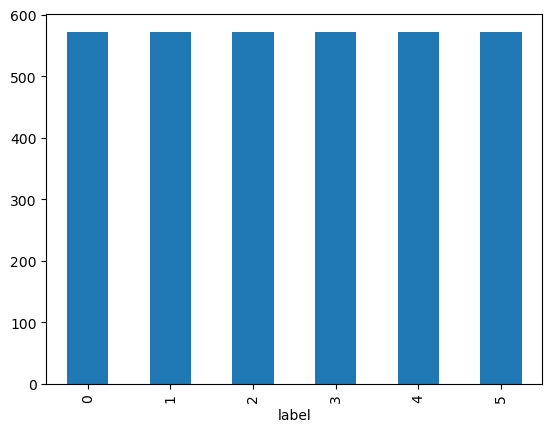

In [13]:
df_train['label'].value_counts().plot(kind="bar")

In [14]:
train_data = datasets.Dataset.from_dict(df_train)

In [15]:
id2label = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

In [16]:
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
model = XLNetForSequenceClassification.from_pretrained(
    "xlnet-base-cased",
    num_labels=6,
    id2label=id2label
)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding = "max_length", max_length = 128, truncation=True)

In [18]:
tokenized_dataset_train = train_data.map(tokenize_function, batched=True)

Map:   0%|          | 0/3432 [00:00<?, ? examples/s]

In [19]:
tokenized_dataset_validation = data["validation"].map(tokenize_function, batched=True)

In [20]:
tokenized_dataset_test = data["test"].map(tokenize_function, batched=True)

## Training the model

In [21]:
training_args = TrainingArguments(output_dir="xlnet_dair_ai_emotion", eval_strategy="epoch", num_train_epochs=3)

In [22]:
metric = evaluate.load("accuracy")

In [23]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_train,
    eval_dataset=tokenized_dataset_validation,
    compute_metrics=compute_metrics
)

In [25]:
trainer.train()

/home/test/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.708479,0.275000
2,1.816500,1.444651,0.426000
3,1.569800,0.704553,0.778500


/home/test/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/test/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/test/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/test/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=1287, training_loss=1.4728947589817951, metrics={'train_runtime': 16480.5519, 'train_samples_per_second': 0.625, 'train_steps_per_second': 0.078, 'total_flos': 733306162507776.0, 'train_loss': 1.4728947589817951, 'epoch': 3.0})

In [26]:
trainer.evaluate()

/home/test/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.7045528292655945,
 'eval_accuracy': 0.7785,
 'eval_runtime': 592.1396,
 'eval_samples_per_second': 3.378,
 'eval_steps_per_second': 0.422,
 'epoch': 3.0}

## Saving the model locally

In this case, it will save both model and tokenizer inside a directory named `xlnet_emotion_model`.
You can find this folder (directory) in your current working directory.

In [27]:
model.save_pretrained("xlnet_emotion_model")
tokenizer.save_pretrained("xlnet_emotion_model")

## Loading local models

In [28]:
fine_tuned_model = XLNetForSequenceClassification.from_pretrained("xlnet_emotion_model")
tokenizer = XLNetTokenizer.from_pretrained("xlnet_emotion_model")

In [29]:
clf = pipeline("text-classification", fine_tuned_model, tokenizer=tokenizer)

Device set to use cpu


<p style="font-size:1.25rem">This model is now ready for classification tasks.</p>